In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer
from typing import Tuple, Dict, List

print(torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

train_transform = torchvision.transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                                  transforms.RandomHorizontalFlip(),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = torchvision.transforms.Compose([transforms.ToTensor(),
                                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root="./data",
                                          train=True,
                                          transform=train_transform,
                                          download=True)

test_dataset = torchvision.datasets.CIFAR10(root="./data",
                                         train=False,
                                         transform=test_transform,
                                         download=True)

BATCH_SIZE = 64
NUM_WORKERS = 0
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=NUM_WORKERS)

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=NUM_WORKERS)
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    """Performs a training step on the model and returns the train loss and accuracy"""
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc
def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              device=device):
    """Performs a testing step on the model and returns the test loss and accuracy"""
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred_logits = model(X)
            loss = loss_fn(y_pred_logits, y)
            test_loss += loss.item()
            y_pred_label = y_pred_logits.argmax(dim=1)
            test_acc += (y_pred_label==y).sum().item()/len(y_pred_label)
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc
def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device=device):
    """Trains the model and returns a dictionary of the results"""
    results = {"Train Loss": [],
               "Train Accuracy": [],
               "Test Loss": [],
               "Test Accuracy": []}
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train_acc: {train_acc:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
        results["Train Loss"].append(train_loss)
        results["Train Accuracy"].append(train_acc)
        results["Test Loss"].append(test_loss)
        results["Test Accuracy"].append(test_acc)

    return results

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Sequential(
            # block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),
            # block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        return self.classifier(self.conv_layer(x))

model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001, momentum=0.9)
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      loss_fn=loss_fn,
                      optimizer=optimizer,
                      epochs=30,
                      device=device)

2.0.1+cu118
cuda
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.8185 | Train_acc: 0.3175 | Test loss: 1.4672, Test acc: 0.4632
Epoch: 1 | Train loss: 1.3428 | Train_acc: 0.5039 | Test loss: 1.2025, Test acc: 0.5732
Epoch: 2 | Train loss: 1.1066 | Train_acc: 0.6004 | Test loss: 0.9440, Test acc: 0.6598
Epoch: 3 | Train loss: 0.9561 | Train_acc: 0.6577 | Test loss: 0.9189, Test acc: 0.6760
Epoch: 4 | Train loss: 0.8519 | Train_acc: 0.6959 | Test loss: 0.8100, Test acc: 0.7096
Epoch: 5 | Train loss: 0.7797 | Train_acc: 0.7233 | Test loss: 0.7480, Test acc: 0.7401
Epoch: 6 | Train loss: 0.7161 | Train_acc: 0.7475 | Test loss: 0.6434, Test acc: 0.7778
Epoch: 7 | Train loss: 0.6677 | Train_acc: 0.7637 | Test loss: 0.6479, Test acc: 0.7802
Epoch: 8 | Train loss: 0.6279 | Train_acc: 0.7798 | Test loss: 0.5717, Test acc: 0.8035
Epoch: 9 | Train loss: 0.5942 | Train_acc: 0.7912 | Test loss: 0.5915, Test acc: 0.7969
Epoch: 10 | Train loss: 0.5615 | Train_acc: 0.8039 | Test loss: 0.5085, Test acc: 0.8244
Epoch: 11 | Train loss: 0.5324 

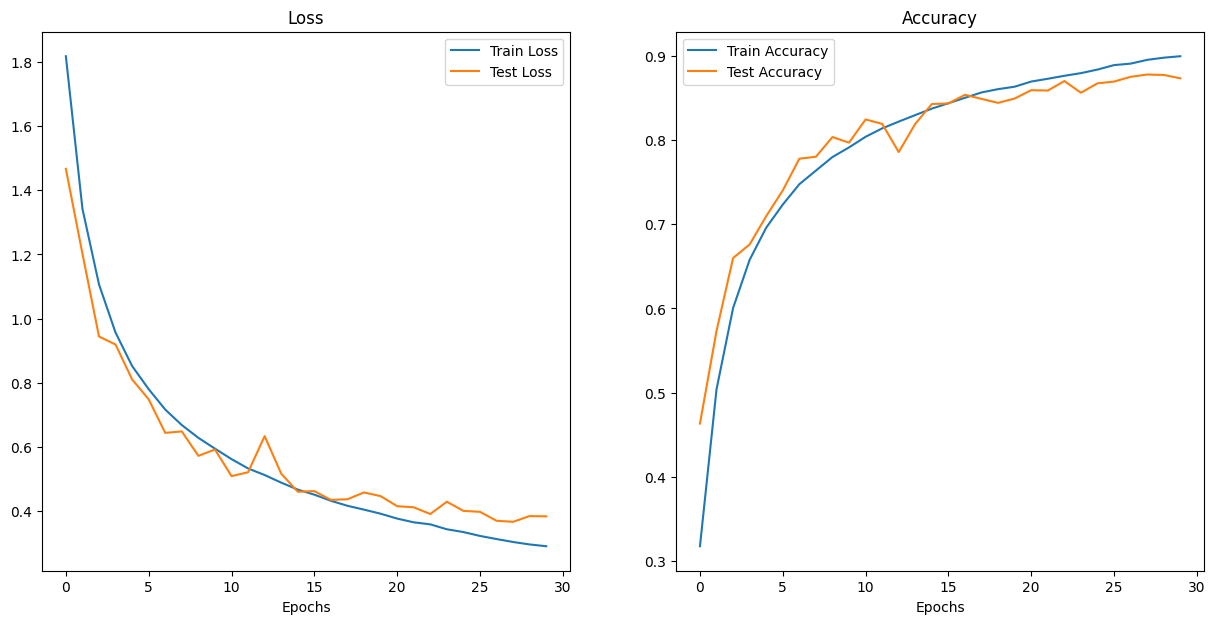

In [6]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary"""
    loss = results["Train Loss"]
    test_loss = results["Test Loss"]
    accuracy = results["Train Accuracy"]
    test_accuracy = results["Test Accuracy"]
    epochs = range(len(results["Train Loss"]))

    plt.figure(figsize=(15,7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, test_loss, label="Test Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="Train Accuracy")
    plt.plot(epochs, test_accuracy, label="Test Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

plot_loss_curves(model_results)